# Real-Time Credit Card Fraud Detection

In [ ]:
# Load packages
import pandas as pd
import numpy as np
from typing import Tuple, Dict

import matplotlib.pyplot as plt
from matplotlib import colors

from modeva import DataSet
from modeva.models import MoCatBoostClassifier
from modeva import TestSuite

# Load Data

In [ ]:
# Load data
fname = 'engineered_fraud_features.csv'
df_feat = pd.read_csv(fname)   # <- Adjust path if needed

# MoDeVa Analysis

In [169]:
# Create MoDeVa dataset object
ds = DataSet() # Create dataset object holder
ds.load_dataframe(data = df_feat) # Load in data to dataset object

In [159]:
# Preprocess the data
ds.encode_categorical(method="ordinal") # Encoding categorical variables as ordinal
ds.scale_numerical(features=tuple(ds.feature_names_numerical), 
                   method="standardize") # Standardized numerical features
ds.set_target('fraud_status') # Set target
ds.preprocess() # Run pre-processing
ds.set_random_split() # Split training and testing, uses a default 80/20 split

In [ ]:
# Classification task using CatBoost
split_idx = int(len(df_feat) * 0.8)
train_df = df_feat.iloc[:split_idx].reset_index(drop=True)
test_df = df_feat.iloc[split_idx:].reset_index(drop=True)
X_train, y_train = train_df.drop(columns=["fraud_status"]), train_df["fraud_status"]

# Handle class imbalance with scale_pos_weight
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Fit Catboost model
model_cat = MoCatBoostClassifier(name = "Cat_model", 
                                 max_depth=3, 
                                 n_estimators=500, 
                                 learning_rate=0.05, 
                                 scale_pos_weight=pos_weight, 
                                 silent=True)
model_cat.fit(ds.train_x, ds.train_y)

# Look at performance metrics for the model
ts_cat = TestSuite(ds, model_cat)
results_cat = ts_cat.diagnose_accuracy_table()
display(results_cat.table)

,AUC,ACC,F1,LogLoss,Brier
train,0.787599,0.611044,0.070747,0.565924,0.202321
test,0.771314,0.606275,0.067279,0.567772,0.203246
GAP,-0.016285,-0.004769,-0.003468,0.001848,0.000925


## Brier Score

In [ ]:
# Test using random forest proximity to create clusters
# Using Brier score as the metric
results_RF = ts_cat.diagnose_residual_cluster(
   dataset="test", # Dataset to use
   response_type="abs_residual", # Response type
   metric="Brier", # Metric to use
   n_clusters=10, # Number of clusters
   cluster_method="pam", # Clustering method
   sample_size=5000, # Sample size
   rf_n_estimators=100, # Number of trees
   rf_max_depth=5 # Max depth of trees
)

results_RF.table # Table of cluster performance

,Brier,Size,abs_residual
9,0.420764,9502.0,0.640844
5,0.336617,2629.0,0.572961
6,0.310032,1565.0,0.551936
2,0.215452,3862.0,0.457820
0,0.163526,9945.0,0.365594
7,0.084416,2009.0,0.277224
3,0.033234,2341.0,0.166943
4,0.009209,2111.0,0.094183
1,0.007506,4190.0,0.070722
8,0.002690,1846.0,0.048777


In [ ]:
# Sanity check: reverse engineering the global Brier score
np.sum((results_RF.table['Size']/np.sum(results_RF.table['Size']))*results_RF.table['Brier'])

0.20324640523578244

In [ ]:
# Show cluster performance and save plots
results_RF.plot_save("cluster_residual", 
                     file_name='images/Cluster_Residuals_Fraud_Brier', 
                     format='png')

results_RF.plot_save("cluster_performance", 
                     file_name='images/Cluster_Performance_Fraud_Brier', 
                     format='png')

In [15]:
# Use cluster with the highest Brier score
cluster_id = 9 # Cluster ID
data_results = ds.data_drift_test(
   **results_RF.value["clusters"][cluster_id]["data_info"], # Use cluster_id
   distance_metric="PSI", # Distance metric using PSI
   psi_method="uniform", # PSI method using uniform distribution
   psi_bins=10 # PSI bins
)

In [ ]:
# Plot and save summary and density plots for cluster with the highest Brier score
data_results.plot_save("summary", 
                       file_name='images/PSI_Brier', 
                       format='png') # Plot summary of data drift test

data_results.plot_save(name=('density', 'merchant_name_risk'), 
                       file_name='images/Density_Comparison_Brier', 
                       format='png')

data_results.plot_save(name=('density', 'fraud_status'), 
                       file_name='images/Density_Fraud_Brier', 
                       format='png')

## AUC

In [ ]:
# Test using random forest proximity to create clusters
# Using AUC as the metric
results_AUC = ts_cat.diagnose_residual_cluster(
   dataset="test", # Dataset to use
   response_type="abs_residual", # Response type
   metric="AUC", # Metric to use
   n_clusters=10, # Number of clusters
   cluster_method="pam", # cClustering method
   sample_size=5000, # Sample size
   rf_n_estimators=100, # Number of trees
   rf_max_depth=5 # Max depth of trees
)

results_AUC.table # Table of cluster performance

,AUC,Size,abs_residual
9,0.593664,9502.0,0.640844
5,0.657775,2629.0,0.572961
6,0.539786,1565.0,0.551936
2,0.639178,3862.0,0.457820
0,0.764214,9945.0,0.365594
7,0.645588,2009.0,0.277224
3,0.847996,2341.0,0.166943
4,NaN,2111.0,0.094183
1,0.586524,4190.0,0.070722
8,NaN,1846.0,0.048777


In [ ]:
# Show cluster performance and save plots
results_AUC.plot_save("cluster_residual", 
                      file_name='images/Cluster_Residuals_Fraud_AUC', 
                      format='png')

results_AUC.plot_save("cluster_performance", 
                      file_name='images/Cluster_Performance_Fraud_AUC', 
                      format='png')

In [ ]:
# Use cluster with the smallest AUC
cluster_id = 6 # Cluster ID
data_results_AUC = ds.data_drift_test(
   **results_AUC.value["clusters"][cluster_id]["data_info"], # Use cluster_id
   distance_metric="PSI", # Distance metric using PSI
   psi_method="uniform", # PSI method using uniform distribution
   psi_bins=10 # PSI bins
)

In [ ]:
# Plot and save summary and density plots for cluster with the smallest AUC
data_results_AUC.plot_save("summary", 
                           file_name='images/PSI_AUC', 
                           format='png') # Plot summary of data drift test

data_results_AUC.plot_save(name=('density', 'merchant_name_risk'), 
                           file_name='images/Density_Comparison_AUC', 
                           format='png')

data_results_AUC.plot_save(name=('density', 'fraud_status'), 
                           file_name='images/Density_Fraud_AUC', 
                           format='png')

## Log Loss

In [ ]:
# Test using random forest proximity to create clusters
# Using log loss as the metric
results_ll = ts_cat.diagnose_residual_cluster(
   dataset="test", # dataset to use
   response_type="abs_residual", # response type
   metric="LogLoss", # metric to use
   n_clusters=10, # number of clusters
   cluster_method="pam", # clustering method
   sample_size=5000, # sample size
   rf_n_estimators=100, # number of trees
   rf_max_depth=5 # max depth of trees
)

results_ll.table # table of cluster performance

,LogLoss,Size,abs_residual
9,1.060023,9502.0,0.640844
5,0.876050,2629.0,0.572961
6,0.816119,1565.0,0.551936
2,0.622240,3862.0,0.457820
0,0.494851,9945.0,0.365594
7,0.333460,2009.0,0.277224
3,0.187847,2341.0,0.166943
4,0.099126,2111.0,0.094183
1,0.076910,4190.0,0.070722
8,0.050178,1846.0,0.048777


In [ ]:
# Show cluster performance
results_ll.plot_save("cluster_residual", 
                     file_name='images/Cluster_Residuals_Fraud_LogLoss', 
                     format='png')

results_ll.plot_save("cluster_performance", 
                     file_name='images/Cluster_Performance_Fraud_LogLoss', 
                     format='png')

In [ ]:
# Use cluster with the highest log loss
cluster_id = 9 # Cluster ID
data_results_ll = ds.data_drift_test(
   **results_ll.value["clusters"][cluster_id]["data_info"], # Use cluster_id
   distance_metric="PSI", # Distance metric using PSI
   psi_method="uniform", # PSI method using uniform distribution
   psi_bins=10 # PSI bins
)

In [ ]:
# Plot and save summary and density plots for cluster with the highest log loss
data_results_ll.plot_save("summary", 
                          file_name='images/PSI_LogLoss', 
                          format='png') # plot summary of data drift test

data_results_ll.plot_save(name=('density', 'merchant_name_risk'), 
                          file_name='images/Density_Comparison_LogLoss', 
                          format='png')

data_results_ll.plot_save(name=('density', 'fraud_status'), 
                          file_name='images/Density_Fraud_LogLoss', 
                          format='png')

# Global AUC Decomposition: Inter- and Intra-Cluster

In [ ]:
def intercluster_auc(
    y_true: np.ndarray,
    y_score: np.ndarray,
    clusters: np.ndarray,
    tie_policy: str = "half"
) -> Dict[str, np.ndarray]:
    """
    Compute intra- and inter-cluster global AUC decomposition

    Parameters
    ----------
    y_true : array-like of shape (n,)
        Binary response labels {0, 1}
    y_score : array-like of shape (n,)
        Continuous scores (i.e., probabilities)
    clusters : array-like of shape (n, )
        Cluster ID for each sample
    tie_policy : {"half", "skip"}
        - "half": count ties as 0.5 using the Mann-Whitney convention
        - "skip": ignore ties, only counts if strictly greater

    Returns
    -------
    result : dict with:
        - 'auc_global'        : scalar float, global AUC via decomposition
        - 'auc_matrix'        : (K, K) array, AUC_ij where i = pos cluster, j = neg cluster
        - 'weight_matrix'     : (K, K) array, w_ij = |P_i||N_j| / (|P||N|)
        - 'contrib_matrix'    : (K, K) array, w_ij * AUC_ij
        - 'auc_intra_total'   : scalar, sum of diagonal contributions
        - 'auc_inter_total'   : scalar, sum of off-diagonal contributions
        - 'cluster_order'     : (K, ) array, the cluster labels in matrix order
    """
    y_true  = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    clusters = np.asarray(clusters)

    if set(np.unique(y_true)) - {0, 1}:
        raise ValueError("y_true must be binary in {0, 1}.")

    # Identify positives and negatives overall
    pos_mask = (y_true == 1)
    neg_mask = (y_true == 0)
    P = np.sum(pos_mask)
    N = np.sum(neg_mask)
    if P == 0 or N == 0:
        raise ValueError("Both positive and negative samples are required.")

    # Cluster bookkeeping
    uniq = np.unique(clusters)
    K = len(uniq)
    idx_by_cluster = {c: np.where(clusters == c)[0] for c in uniq}

    # Split each cluster into its P_i and N_i
    P_idx = {c: idx_by_cluster[c][y_true[idx_by_cluster[c]] == 1] for c in uniq}
    N_idx = {c: idx_by_cluster[c][y_true[idx_by_cluster[c]] == 0] for c in uniq}

    # Weight matrix w_ij
    weight = np.zeros((K, K), dtype=float)
    for i, ci in enumerate(uniq):
        for j, cj in enumerate(uniq):
            weight[i, j] = (len(P_idx[ci]) * len(N_idx[cj])) / (P * N) if (P*N) else 0.0

    # Compute AUC_ij using sorted negatives for O(|P_i| log |N_j|)
    def auc_ij(pos_scores: np.ndarray, neg_scores: np.ndarray) -> float:
        npos = pos_scores.size
        nneg = neg_scores.size
        if npos == 0 or nneg == 0:
            return np.nan  # If no pairs, since weight will be zero anyway

        # Sort negatives once, then binary-search counts for each positive
        neg_sorted = np.sort(neg_scores)
        
        # Count of negatives strictly less than each pos score
        strictly_less = np.searchsorted(neg_sorted, pos_scores, side="left")
        
        # Count of negatives <= each pos score
        less_or_equal = np.searchsorted(neg_sorted, pos_scores, side="right")

        if tie_policy == "half":
            ties = less_or_equal - strictly_less
            wins = strictly_less + 0.5 * ties
        elif tie_policy == "skip":
            wins = strictly_less
        else:
            raise ValueError("tie_policy must be 'half' or 'skip'.")

        total_pairs = npos * nneg
        return float(np.sum(wins) / total_pairs)

    # Build the AUC matrix
    auc_mat = np.zeros((K, K), dtype=float)
    for i, ci in enumerate(uniq):
        pos_scores = y_score[P_idx[ci]]
        for j, cj in enumerate(uniq):
            neg_scores = y_score[N_idx[cj]]
            auc_mat[i, j] = auc_ij(pos_scores, neg_scores)

    # Contribution matrix and totals
    contrib = weight * np.nan_to_num(auc_mat, nan=0.0)
    auc_global = float(np.sum(contrib))
    intra_total = float(np.sum(np.diag(contrib)))
    inter_total = float(auc_global - intra_total)

    return {
        "auc_global": auc_global,
        "auc_matrix": auc_mat,
        "weight_matrix": weight,
        "contrib_matrix": contrib,
        "auc_intra_total": intra_total,
        "auc_inter_total": inter_total,
        "cluster_order": uniq
    }

In [ ]:
def _cluster_counts(y_true, clusters):
    clusters = np.asarray(clusters)
    y_true = np.asarray(y_true).astype(int)
    uniq = np.unique(clusters)
    pos_mask = (y_true == 1)
    neg_mask = ~pos_mask
    P = int(np.sum(pos_mask)); N = int(np.sum(neg_mask))
    P_i = {c: int(np.sum(pos_mask[clusters == c])) for c in uniq}
    N_i = {c: int(np.sum(neg_mask[clusters == c])) for c in uniq}
    return uniq, P, N, P_i, N_i

def print_intercluster_auc_report(result, y_true=None, clusters=None, digits=4):
    """
    Summary output for the inter-/intra-cluster AUC decomposition.

    Parameters
    ----------
    result : dict
        Output from intercluster_auc()
    y_true, clusters : array-like (optional)
        Only needed to print per-cluster counts
    digits : int
        Number of decimals to display
    """
    fmt = f"{{:.{digits}f}}"
    order = result["cluster_order"]
    auc_mat = result["auc_matrix"]
    w = result["weight_matrix"]
    contrib = result["contrib_matrix"]

    print("="*72)
    print("Inter-/Intra-Cluster AUC Decomposition")
    print("="*72)
    print(f"Global AUC   : {fmt.format(result['auc_global'])}")
    print(f" Intra total : {fmt.format(result['auc_intra_total'])}")
    print(f" Inter total : {fmt.format(result['auc_inter_total'])}")
    print("-"*72)

    # Optional per-cluster counts
    if y_true is not None and clusters is not None:
        order_counts = {}
        uniq, P, N, P_i, N_i = _cluster_counts(y_true, clusters)
        
        for c in order: # Map counts to the matrix order
            order_counts[c] = (P_i.get(c, 0), N_i.get(c, 0))
        print("Counts by cluster (|P_i|, |N_i|):")
        
        for c in order:
            pi, ni = order_counts[c]
            print(f"  {c}: ({pi}, {ni})")
        print("-"*72)

    # Per-cluster (row/col) summaries
    print("Per-cluster summaries:")
    print("  Row i (positives from cluster i):")
    for i, ci in enumerate(order):
        row_w = np.sum(w[i, :])
        row_contrib = np.sum(contrib[i, :])
        intra = auc_mat[i, i]
        inter_weighted_auc = (np.sum((w[i, :] * auc_mat[i, :])) / row_w) if row_w > 0 else np.nan
        print(f"    {ci}: intra AUC = {fmt.format(intra)} | "
              f"row-weighted AUC = {fmt.format(inter_weighted_auc)} | "
              f"contribution sum = {fmt.format(row_contrib)}")

    print("  Column j (negatives from cluster j):")
    for j, cj in enumerate(order):
        col_w = np.sum(w[:, j])
        col_contrib = np.sum(contrib[:, j])
        col_weighted_auc = (np.sum((w[:, j] * auc_mat[:, j])) / col_w) if col_w > 0 else np.nan
        print(f"    {cj}: col-weighted AUC={fmt.format(col_weighted_auc)} | "
              f"contribution sum={fmt.format(col_contrib)}")
    print("-"*72)

    # Small matrix preview
    def row_str(r): return " ".join(fmt.format(x) if np.isfinite(x) else "  nan" for x in r)
    print("AUC_ij matrix (i = positive cluster, j = negative cluster):")
    for i, ci in enumerate(order):
        print(f"  {ci:>8} | {row_str(auc_mat[i, :])}")
    print("Weights w_ij:")
    for i, ci in enumerate(order):
        print(f"  {ci:>8} | {row_str(w[i, :])}")
    print("="*72)


def plot_intercluster_auc_heatmap(result, title="Inter-/Intra-Cluster AUC", show_values=True,  cmap="viridis"):
    """
    Create a heatmap of AUC_ij (i = positive cluster, j = negative cluster).
    
    Parameters
    ----------
    result : dict
        Output from intercluster_auc()
    title : str
        Title for the heatmap
    show_values : Boolean
        If AUC values are to shown within each heatmap square
    cmap : str
        Color mapping used for the heatmap, default is 'viridis'
    """
    # Pull values to be plotted
    auc_mat = result["auc_matrix"]
    labels = result["cluster_order"]

    # Create subplot structure
    fig, ax = plt.subplots(figsize=(max(6, 0.8*len(labels)+2), max(5, 0.8*len(labels)+2)))
    im = ax.imshow(auc_mat, aspect="auto", cmap=cmap)

    # Ticks and labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, ha="right")
    ax.set_yticklabels(labels)
    ax.set_xlabel("Negatives from cluster j")
    ax.set_ylabel("Positives from cluster i")
    ax.set_title(title)
    
    # Normalize to the colormap to decide text color
    norm = colors.Normalize(vmin=np.nanmin(auc_mat), vmax=np.nanmax(auc_mat))
    cmap_obj = plt.get_cmap(cmap)

    # Optional per-cell text
    if show_values:
        nrows, ncols = auc_mat.shape
        for i in range(nrows):
            for j in range(ncols):
                val = auc_mat[i, j]
                if np.isfinite(val):
                    # Get the RGB colors for the cell
                    r, g, b, _ = cmap_obj(norm(val))
                    
                    # Compute perceived brightness
                    brightness = 0.299*r + 0.587*g + 0.114*b
                    text_color = "white" if brightness < 0.5 else "black"
                    ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=text_color)

    fig.colorbar(im, ax=ax, shrink=0.85)
    fig.tight_layout()
    plt.show()

In [ ]:
# Pull clusters from the MoDeVa dataset object
hold = pd.DataFrame(ds.test_y)
hold['cluster_id'] = 999
cluster_id = np.arange(0, 10)
for id in cluster_id:
    index_list = results_AUC.value["clusters"][id]["data_info"]['sample_idx1']
    hold['cluster_id'] = np.where(hold.index.isin(index_list), id, hold['cluster_id'])
    
predicted_probs = model_cat.predict_proba(ds.test_x)[:, 1] # Predicted probabilities for class 1
actual = np.hstack(ds.test_y) # Actual observations
cluster = np.array(hold['cluster_id']) # Clusters

In [ ]:
# Perform global AUC deocomposition and show output
decomp = intercluster_auc(y_true=actual, 
                          y_score=predicted_probs, 
                          clusters=cluster)
decomp

{'auc_global': 0.7713138008858491,
 'auc_matrix': array([[7.64214115e-01, 9.90194744e-01, 6.74778788e-01, 9.74865640e-01,
         9.85686696e-01, 3.74407127e-01, 4.22317251e-01, 9.44223030e-01,
         9.93461955e-01, 2.39763806e-01],
        [7.41139655e-02, 5.86523684e-01, 7.14473734e-04, 5.92125406e-02,
         3.07031197e-01, 0.00000000e+00, 0.00000000e+00, 8.47944812e-03,
         7.78594645e-01, 6.25743070e-05],
        [7.43840413e-01, 9.99677455e-01, 6.39178230e-01, 9.92420686e-01,
         9.99992481e-01, 1.96673870e-01, 2.54362744e-01, 9.75974897e-01,
         1.00000000e+00, 4.94389170e-02],
        [3.19612837e-01, 9.92798231e-01, 8.03171887e-02, 8.47996142e-01,
         9.98401232e-01, 1.02699531e-02, 1.38162198e-02, 4.78181590e-01,
         1.00000000e+00, 3.55891371e-03],
        [           nan,            nan,            nan,            nan,
                    nan,            nan,            nan,            nan,
                    nan,            nan],
        [9.

Inter-/Intra-Cluster AUC Decomposition
Global AUC   : 0.7713
 Intra total : 0.1203
 Inter total : 0.6510
------------------------------------------------------------------------
Counts by cluster (|P_i|, |N_i|):
  0: (130, 9815)
  1: (7, 4183)
  2: (63, 3799)
  3: (8, 2333)
  4: (0, 2111)
  5: (73, 2556)
  6: (36, 1529)
  7: (21, 1988)
  8: (0, 1846)
  9: (370, 9132)
------------------------------------------------------------------------
Per-cluster summaries:
  Row i (positives from cluster i):
    0: intra AUC=0.7642 | row-weighted AUC=0.6634 | contribution sum=0.1218
    1: intra AUC=0.5865 | row-weighted AUC=0.1381 | contribution sum=0.0014
    2: intra AUC=0.6392 | row-weighted AUC=0.5972 | contribution sum=0.0531
    3: intra AUC=0.8480 | row-weighted AUC=0.3705 | contribution sum=0.0042
    4: intra AUC=nan | row-weighted AUC=nan | contribution sum=0.0000
    5: intra AUC=0.6578 | row-weighted AUC=0.8027 | contribution sum=0.0828
    6: intra AUC=0.5398 | row-weighted AUC=0.703

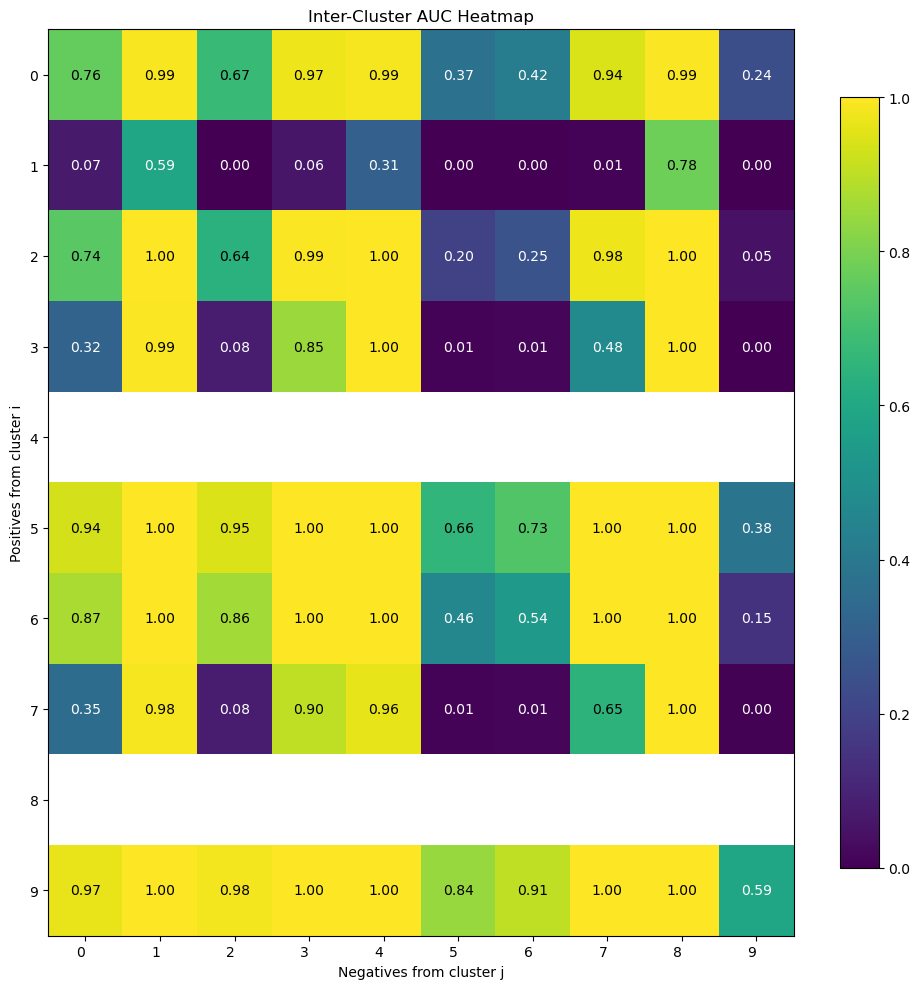

In [ ]:
# Show summary and plot of AUC decomposition
print_intercluster_auc_report(decomp, 
                              y_true=actual, 
                              clusters=cluster, 
                              digits=4)

plot_intercluster_auc_heatmap(decomp, 
                              title="Inter-Cluster AUC Heatmap")